# Neural typicality (NT)

Neural typicality (see Davis & Poldrack, 2014) is a measure of how similar a stimulus response is to the responses to other same-category stimuli. That is, it quantifies how typical an exemplar is for its category, as measured by neural response.

Since we have no fMRI data (yet), we'll try to calculate a similar measure based on the HMAX outputs. We can seperate two different measures: *Conserved and newfound typicality*.

1) Conserved typcality
- How typical is an RI percept for the category representation *before vision loss*.
- Average difference between HMAX output of a *simulated image* to the HMAX outputs of *original images of the same category*.

2) Newfound typicality
- How typical is an RI percept for the category representation *after vision loss*.
- Average difference between HMAX output of a *simulated image* to the HMAX outputs of *the other simulated images of that same category*.


# Description in Davis & Poldrack (2014)

## Distance d
Formally, our neural typicality measure is based on the distance d between patterns of activation elicited for a stimulus i and those elicited for other j members of its category

\begin{equation*}
d_{ij} = \frac{1 - corr(\beta_{i}, \beta_{j}) }{2}
\end{equation*}

where the *β’s are trial-by-trial β-series estimates of the pattern of activation elicited for each j stimulus*. A *Pearson correlation distance metric* is used because it normalizes for differences in mean activation level and variability between stimuli. This property makes correlation distance potentially less susceptible to differences in univariate activation between stimuli than other distance metrics (Kriegeskorte, Mur, Bandettini et al. 2008), assuming that the distribution of activation over voxels within an region of interest (ROI) is homogenous and does not reflect a mixture of signals.


## Similarity S

The distance between the activation patterns for i and j is transformed to similarity S by:

\begin{equation*}
S_{ij} = exp( - d_{ij})
\end{equation*}

where the *exponential instantiates a generalization gradient* that determines the form by which similarity decreases as a function of the distance between the patterns of activation for stimulus i and j. Statistically, instituting a generalization gradient *reduces the impact of stimuli that are distant* from stimulus i on the neural typicality computation. The exponential gradient is a common choice in exemplar models following the finding that the relationship between distance and similarity in psychological spaces tends to be exponential (Shepard’s Universal Law; Shepard 1987).

## Neural typicality typ()

Finally, neural typicality (typ) is computed by summing the pairwise similarities between i and each j member of Category J:

\begin{equation*}
typ( i \mid J) = \sum_{j \in J} s_{ij}
\end{equation*}

In [1]:
import pandas as pd
import glob
import numpy as np
from scipy.stats import pearsonr
from numpy import exp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
% matplotlib inline

# Load data

In [3]:
"""
Construct list of dicts containing information about our HMAX outputs.
"""

pattern_dicts = []
for hmax_file in glob.glob('./results/*'):
    # get hmax output vector
    hmax_df = pd.read_csv(hmax_file, header=None)
    pattern = np.array([row[0] for row in hmax_df.values])
    assert len(pattern) == 2000
    # get category and stimulus name
    # we can later find the category name in the behavioral data frames again under:
    # np.unique(behav_df.ImgName.values)
    stimname = hmax_file.split('/')[-1].split('_')[0]
    catname = stimname.split('.')[0]
    # is this an ri percept or original image?
    if 'percept' in hmax_file:
        vision = 'ri_percept'
    else:
        vision= 'normal'
    # save to dict
    pattern_dict = {
        'pattern' : pattern,
        'category' : catname,
        'stim' : stimname,
        'vision' : vision,
        'filename' : hmax_file.replace('./results/', '')
    }
    pattern_dicts.append(pattern_dict)

In [4]:
"""
Refactor into one big data frame, where each row is a stimulus.
"""

hmax_dict = dict()
for keyname in pattern_dicts[0].keys():
    keyname_series = pd.Series([pattern_dict[keyname] for pattern_dict in pattern_dicts])
    hmax_dict[keyname] = keyname_series
hmax_df = pd.DataFrame(hmax_dict)

In [5]:
hmax_df.head()

,category,filename,pattern,stim,vision
0,Flasche,Flasche.6_v2_percept.png.ascii,"[0.35722607449457044, 0.4588070738264219, 0.52...",Flasche.6,ri_percept
1,Tasse,Tasse.2_v2_percept.png.ascii,"[0.3785257550324148, 0.4285361299477676, 0.452...",Tasse.2,ri_percept
2,Schere,Schere.3_v2_percept.png.ascii,"[0.4312964441329005, 0.5035038391512091, 0.539...",Schere.3,ri_percept
3,Glas,Glas.1_v1_new.jpg.ascii,"[0.7922538830570216, 0.8534155946631166, 0.913...",Glas.1,normal
4,Apfel,Apfel.6_v1_new.jpg.ascii,"[0.8132850994190856, 0.8546069253933479, 0.900...",Apfel.6,normal


# Implement computation of NT

In [6]:
def compute_s(pattern1, pattern2):
    """
    Compute similarity measure as in Davis & Poldrack (2014)
    """
    d = (1-pearsonr(pattern1, pattern2)[0]) / 2
    s = exp(-d)
    return s

In [7]:
def compute_typ(similarities):
    """
    sum a list of pairwise similarities to obtain typicality
    """
    np.sum(similarities)

# Actually compute both typicality measures and add to data frame

i.e. neural typicality among RI percepts.

In [8]:
def compute_typicality(hmax_df, which_nt='newfound'):

    # filter data frame for ri_percepts only
    ri_df = hmax_df[hmax_df.vision=='ri_percept']

    # iterate through ri_percept stimuli
    for row in ri_df.filename:
        # get category names, and filter for within-category patterns
        catname = ri_df[ri_df.filename == row].category.values[0]
        target_pattern = ri_df[ri_df.filename==row].pattern.values[0]
        assert len(target_pattern) == 2000

        # slice data frame to get within-category exemplars,
        # depending on wether we want newfound or conserved typicality
        if which_nt == 'newfound':
            cat_df = ri_df[(ri_df.category == catname) & (ri_df.filename != row)]
            colname = 'newNT'
            check_len = 7
        elif which_nt == 'conserved':
            cat_df = hmax_df[(hmax_df.category == catname) & (hmax_df.vision == 'normal')] 
            colname = 'conNT'
            check_len = 9
        else:
            raise InputError("Sorry, I don't know the typicality of type %s" % which_nt)

        # pairwise similarities for within-category exemplars
        similarities = [compute_s(target_pattern, cat_pattern)
                        for cat_pattern in cat_df.pattern.values]    
        assert len(similarities) == check_len

        # sum over similarities to get typicality
        NT = np.sum(similarities)
        # insert result into df
        row_index = ri_df.index[ri_df.filename == row].tolist()[0]
        ri_df.loc[row_index, colname] = NT

    # check for NaN    
    assert True not in ri_df[colname].isnull().values
    
    """
    also create centered version whilst we're at it
    """    
    NT_mean = np.mean(ri_df[colname].values)
    NT_cent = ri_df[colname].values - NT_mean
    ri_df[colname+'_cent'] = NT_cent
    # check for NaN
    assert True not in ri_df[colname].isnull().values
    
    return ri_df

In [9]:
"""
Get data frame with newfound and conserved NT respectively and merge into one
"""

# individual dfs
ri_df_new = compute_typicality(hmax_df, which_nt='newfound')
ri_df_con = compute_typicality(hmax_df, which_nt='conserved')

# merge
nt_df = pd.merge(ri_df_new, ri_df_con, on=['filename', 'category', 'stim', 'vision'])
assert len(nt_df) == len(ri_df_new) and len(nt_df) == len(ri_df_con)

# for some reason, pattern is not a valid key for merging (presumably because of array structure)
# So we're gonna rename and drop
nt_df['pattern'] = nt_df.pattern_x
nt_df = nt_df.drop(columns=['pattern_x', 'pattern_y'])

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [19]:
np.std(nt_df['newNT'].values)

0.0037265548312722095

In [33]:
"""
z-standardize 
"""
for colname in ['newNT', 'conNT']:
    nt_df['%s_z' % colname] = (nt_df[colname] - np.mean(nt_df[colname].values)) / np.std(nt_df[colname].values)

In [34]:
nt_df.head()

,category,filename,stim,vision,newNT,newNT_cent,conNT,conNT_cent,pattern,newNT_z,conNT_z
0,Flasche,Flasche.6_v2_percept.png.ascii,Flasche.6,ri_percept,6.994057,0.000579,8.713323,-0.027473,"[0.35722607449457044, 0.4588070738264219, 0.52...",0.155435,-0.488992
1,Tasse,Tasse.2_v2_percept.png.ascii,Tasse.2,ri_percept,6.991166,-0.002311,8.771453,0.030657,"[0.3785257550324148, 0.4285361299477676, 0.452...",-0.620205,0.545661
2,Schere,Schere.3_v2_percept.png.ascii,Schere.3,ri_percept,6.995004,0.001527,8.678519,-0.062277,"[0.4312964441329005, 0.5035038391512091, 0.539...",0.409639,-1.108479
3,Tasse,Tasse.7_v2_percept.png.ascii,Tasse.7,ri_percept,6.996475,0.002998,8.795593,0.054796,"[0.4188716849582336, 0.4966029639347497, 0.535...",0.804442,0.975325
4,Flasche,Flasche.3_v2_percept.png.ascii,Flasche.3,ri_percept,6.996448,0.002971,8.728509,-0.012287,"[0.42703167107325457, 0.5060960679515243, 0.56...",0.797173,-0.218701


In [35]:
"""
Save the resulting data frame as a pickle file
"""
pickle.dump(nt_df, open( "nt_df.p", "wb" ))

# Descriptive plotting

Text(0.5,1,'scatter plot: conNT by newNT')

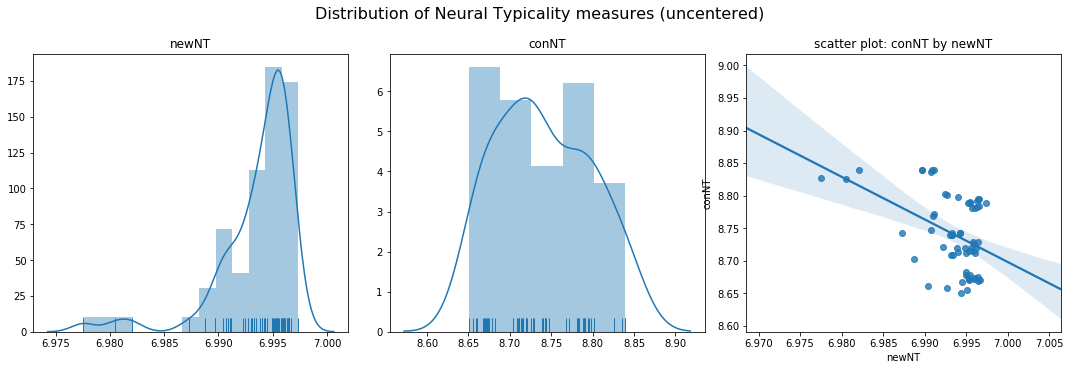

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

fig.suptitle('Distribution of Neural Typicality measures (uncentered)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

for axis, nt in zip(axs[:-1], ['newNT', 'conNT']):
    sns.distplot(nt_df[nt].values, rug=True, ax=axis)
    axis.set_title(nt)
    
sns.regplot(x='newNT', y='conNT', data=nt_df, ax=axs[-1])
axs[-1].set_title('scatter plot: conNT by newNT')

In [37]:
r, p = pearsonr(nt_df.newNT.values, nt_df.conNT.values)
print('Correlation newNT and conNT: r = %f; p = %f' % (r,p))

Correlation newNT and conNT: r = -0.433835; p = 0.000342
